# Topic models with Gensim

Gensim is a popular library for topic modeling. Here we'll see how it stacks up to scikit-learn.

<p class="reading-options">
  <a class="btn" href="/text-analysis/topic-models-with-gensim">
    <i class="fa fa-sm fa-book"></i>
    Read online
  </a>
  <a class="btn" href="/text-analysis/notebooks/Topic models with Gensim.ipynb">
    <i class="fa fa-sm fa-download"></i>
    Download notebook
  </a>
  <a class="btn" href="https://colab.research.google.com/github/littlecolumns/ds4j-notebooks/blob/master/text-analysis/notebooks/Topic models with Gensim.ipynb" target="_new">
    <i class="fa fa-sm fa-laptop"></i>
    Interactive version
  </a>
</p>

### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **recipes.csv:** recipes - a list of recipes (but only with ingredient names)
* **state-of-the-union.csv:** State of the Union addresses - each presidential address from 1970 to 2012


In [1]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://raw.githubusercontent.com/patchworquill/sfi_complexity/master/merged.csv

--2022-07-17 21:16:53--  https://raw.githubusercontent.com/patchworquill/sfi_complexity/master/merged.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3555987 (3.4M) [text/plain]
Saving to: ‘merged.csv’

merged.csv          100%[===================>]   3.39M  --.-KB/s    in 0.07s   

2022-07-17 21:16:54 (49.1 MB/s) - ‘merged.csv’ saved [3555987/3555987]



In [2]:
import pandas as pd

df = pd.read_csv("merged.csv",sep="\t", names=["episodes", "content"], error_bad_lines=False, engine="python") # Skip the offending lines

df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
Skipping line 39: field larger than field limit (131072)


,episodes,content
0,0,Episode Details / Transcript Michael: So David...
1,1,Episode Details / Transcript Michael: Welcome ...
2,2,Episode Details / Transcript Michael: Well Sab...
3,3,"Episode Details / Transcript Michael: Luis, it..."
4,4,Episode Details / Transcript Michael: Jennifer...


In [ ]:
# from wordcloud import WordCloud

# total_string=""

# for i in range(0,69):
#   total_string += df.iat[i,1]

# wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
#   # Generate a word cloud
# wordcloud.generate(total_string)
# # Visualize the word cloud
# im = wordcloud.to_image()

# fp = "main-wordcloud.png"
# im.save(fp, format="png")

In [ ]:
# total_string += df.iat[i,1]
#   # Create a WordCloud object

# wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# # Generate a word cloud
# wordcloud.generate(long_string)
# # Visualize the word cloud
# im = wordcloud.to_image()

# fp = str(i)+"-wordcloud.png"
# im.save(fp, format="png")

In [ ]:
# !zip -r /content/file.zip /content/wordcloud

## Using Gensim

In [ ]:
#!pip install --upgrade gensim

In [3]:
from gensim.utils import simple_preprocess

texts = df.content.apply(simple_preprocess)

In [4]:
from gensim import corpora

dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5)

corpus = [dictionary.doc2bow(text) for text in texts]

In [5]:
from gensim import models

tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [6]:
n_topics = 70

# Build an LSI model
lsi_model = models.LsiModel(corpus_tfidf,
                            id2word=dictionary,
                            num_topics=n_topics)

In [7]:
lsi_model.print_topics()

[(0,
  '0.085*"cell" + 0.082*"disease" + 0.079*"cities" + 0.077*"virus" + 0.076*"cells" + 0.068*"city" + 0.067*"andy" + 0.066*"growth" + 0.064*"epidemic" + 0.064*"ants"'),
 (1,
  '-0.224*"andy" + -0.219*"disease" + -0.208*"epidemic" + -0.182*"outbreak" + -0.145*"immunity" + -0.145*"diseases" + -0.144*"sam" + -0.137*"contagions" + -0.136*"transmission" + -0.136*"infected"'),
 (2,
  '0.203*"cell" + 0.174*"cells" + 0.130*"bacteria" + 0.121*"chris" + -0.120*"art" + 0.119*"scaling" + 0.118*"eukaryotes" + 0.110*"cities" + 0.109*"andy" + 0.104*"biochemistry"'),
 (3,
  '0.229*"jennifer" + 0.223*"webs" + 0.216*"web" + -0.194*"economics" + -0.180*"equilibrium" + -0.178*"mathematics" + -0.147*"began" + 0.126*"fish" + -0.118*"brian" + -0.107*"verbs"'),
 (4,
  '-0.345*"ants" + -0.162*"economics" + -0.142*"colony" + -0.140*"verbs" + 0.139*"van" + 0.136*"chemical" + -0.133*"robots" + -0.130*"equilibrium" + -0.129*"farmer" + -0.124*"mathematics"'),
 (5,
  '0.377*"ants" + -0.201*"jennifer" + -0.190*"we

Gensim is all about how important each word is to the category. Why not visualize it? First we'll make a dataframe that shows each topic, its top five words, and its values.

In [8]:
n_words = 10

topic_words = pd.DataFrame({})

for i, topic in enumerate(lsi_model.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [dictionary[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

topic_words.head()

,value,word,topic
0,0.084752,cell,0
1,0.082347,disease,0
2,0.078919,cities,0
3,0.077438,virus,0
4,0.076268,cells,0


Then we'll use seaborn to visualize it.

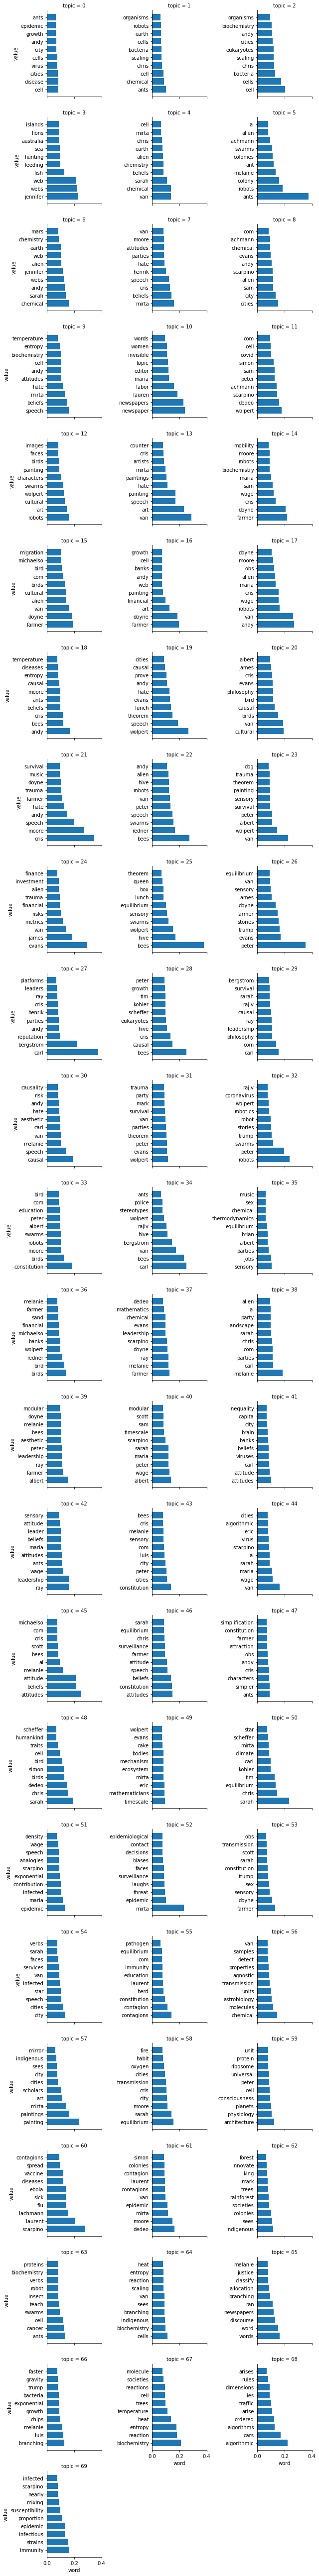

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(topic_words, col="topic", col_wrap=3, sharey=False)
g.map(plt.barh, "word", "value")

## Using LDA with Gensim

Now we'll use LDA.

In [10]:
from gensim.utils import simple_preprocess

texts = df.content.apply(simple_preprocess)

In [11]:
from gensim import corpora

dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=2000)
corpus = [dictionary.doc2bow(text) for text in texts]

In [12]:
from gensim import models

n_topics = 70

lda_model = models.LdaModel(corpus=corpus, num_topics=n_topics)

In [13]:
lda_model.print_topics()

[(22,
  '0.007*"57" + 0.006*"1234" + 0.006*"58" + 0.006*"1813" + 0.005*"1113" + 0.004*"319" + 0.004*"1394" + 0.003*"137" + 0.003*"531" + 0.003*"1325"'),
 (10,
  '0.005*"254" + 0.004*"58" + 0.004*"10" + 0.003*"842" + 0.003*"1093" + 0.003*"1860" + 0.003*"531" + 0.003*"696" + 0.003*"239" + 0.003*"1813"'),
 (61,
  '0.007*"1110" + 0.006*"648" + 0.006*"1721" + 0.005*"136" + 0.004*"1188" + 0.003*"531" + 0.003*"96" + 0.003*"255" + 0.003*"319" + 0.003*"338"'),
 (46,
  '0.006*"1699" + 0.005*"1110" + 0.005*"864" + 0.005*"1071" + 0.004*"96" + 0.004*"1892" + 0.004*"1860" + 0.004*"419" + 0.004*"840" + 0.003*"531"'),
 (33,
  '0.007*"58" + 0.006*"648" + 0.006*"57" + 0.004*"1721" + 0.004*"1110" + 0.003*"254" + 0.003*"1188" + 0.003*"255" + 0.003*"96" + 0.003*"444"'),
 (32,
  '0.006*"96" + 0.005*"1398" + 0.004*"913" + 0.004*"1860" + 0.003*"468" + 0.003*"1892" + 0.003*"1767" + 0.003*"1751" + 0.003*"1500" + 0.003*"1083"'),
 (35,
  '0.005*"1958" + 0.004*"729" + 0.004*"1398" + 0.004*"696" + 0.004*"745" + 0.0

In [14]:
!pip install pyLDAvis
!pip install --upgrade pandas==1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 2.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=4005c6cf197a5e0f3eee8d48b1a4c3cdab2c51cf64f586f74df6a9a6a594ad6b
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.9 MB 3.0 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

print(pyLDAvis.__version__)

pyLDAvis.enable_notebook()
lda_viz = gensimvis.prepare(lda_model, corpus, dictionary)
lda_viz

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


3.3.1


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.000803 -0.000607       1        1  12.533614
36    -0.029358  0.007070       2        1   9.771405
47    -0.014433 -0.014819       3        1   9.078450
41     0.004047  0.013063       4        1   7.293889
64     0.006769 -0.009643       5        1   5.337614
...         ...       ...     ...      ...        ...
18     0.009021  0.006336      66        1   0.001447
19     0.009880 -0.008832      67        1   0.001447
53     0.027125  0.015723      68        1   0.001447
21     0.022709  0.011792      69        1   0.001447
61     0.010861 -0.017777      70        1   0.001447

[70 rows x 5 columns], topic_info=           Term        Freq       Total Category  logprob  loglift
57       cities  265.000000  265.000000  Default  30.0000  30.0000
58         city  232.000000  232.000000  Default  29.0000  29.0000
1110  economics  253.000000  253.000000  Default  28.0000  28.0000
531        cell  168.000000  168.000000  Default  27.0000  27.0000
319   organisms  162.000000  162.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
532       cells    0.002048  133.984356  Topic70  -6.2035   0.0548
643      growth    0.002053  138.294878  Topic70  -6.2012   0.0254
1234    scaling    0.002027  152.751905  Topic70  -6.2140  -0.0868
233      inside    0.001870  105.991547  Topic70  -6.2944   0.1982
1398       word    0.001840  116.296471  Topic70  -6.3105   0.0893

[4161 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1998      1  0.169484  aaron
1998      2  0.084742  aaron
1998      3  0.084742  aaron
1998      4  0.084742  aaron
1998      5  0.084742  aaron
...     ...       ...    ...
474       7  0.059919   zone
474       9  0.059919   zone
474      13  0.059919   zone
474      16  0.059919   zone
474      27  0.059919   zone

[21157 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 37, 48, 42, 65, 31, 16, 28, 7, 21, 58, 1, 69, 15, 35, 45, 18, 55, 63, 57, 34, 53, 43, 23, 9, 3, 61, 8, 17, 5, 25, 36, 56, 27, 14, 10, 52, 60, 29, 6, 11, 67, 59, 30, 66, 70, 49, 46, 24, 26, 68, 51, 4, 50, 47, 44, 41, 40, 12, 13, 39, 38, 64, 33, 32, 19, 20, 54, 22, 62])

In [15]:
import pickle
pickle.dump( lda_viz, open( "lda_vis.p", "wb" ))

NameError: ignored